In [2]:
import csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm_notebook as tqdm
import random

from skimage.transform import resize 
from skimage.io import imread
from sklearn.metrics import accuracy_score

import keras
import tensorflow
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.resnet_v2 import preprocess_input as pi_rnv2
from tensorflow.keras.applications.vgg19 import preprocess_input as pi_vgg19
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as pi_mobv2
from tensorflow.keras.applications.xception import preprocess_input as pi_xcep

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from keras import callbacks

from keras.models import load_model
import keras.utils as image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from catboost import CatBoostClassifier, Pool, sum_models
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

%matplotlib inline
sns.set()

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# VGG_19 + CatBoost + Flatten

In [3]:
%%time
#Валидация

model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0)
        x = pi_vgg19(x) / 255

        data.append(x)
        target_arr.append(i)

print(f'Predict VGG19')
arrays = model_vgg_19.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data

data_arr = []

for arr in arrays:
    data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Данные для валидации готовы!')

<timed exec>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict VGG19 № 1
Данные для валидации готовы!
CPU times: total: 22min 43s
Wall time: 12min 2s


In [42]:
#Смотрим размер выходного (последнего) тензора
from tensorflow.keras.applications import VGG19

model = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

input_image = tensorflow.random.normal((1, 224, 224, 3))
output = model(input_image)

print(output.shape)
print(output.shape[1] * output.shape[2] * output.shape[3])

(1, 7, 7, 512)
25088


In [4]:
#Смотрим размер выходного (последнего) тензора
from tensorflow.keras.applications import DenseNet201

model = DenseNet201(
                    weights = 'imagenet', 
                    include_top = False, 
                    input_shape = (224, 224, 3)
                   )

input_image = tensorflow.random.normal((1, 224, 224, 3))
output = model(input_image)

print('Tensor:', output.shape)
print('Flatten:', output.shape[1] * output.shape[2] * output.shape[3])

Tensor: (1, 7, 7, 1920)
Flatten: 94080


In [ ]:
%%time
#Для предобученной сети
model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

folder_name = [
               'trash',
               'wf', 
               'prefin', 
               #'econ', 
               'stand', 
               #'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ]

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN_8\train'
val_names = os.listdir(val_path) 

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 100 #количество фото на все классы в 1 batch
h = 0       #шаг, после остановки модели и ее продолжении необходимо изменить h. Для следующих 100 итераций h = 

# catc = CatBoostClassifier(iterations = 100, #максимальное количество построенных деревьев
#                           random_seed = 5, 
#                           learning_rate = 0.03, #скорость обучения, определяет насколько быстро или медленно модель 
#                                                  #будет учиться
#                           max_depth = 5, #глубина дерева, учим на пеньках, чтобы небыло переобучения
#                           l2_leaf_reg = 5, #коэффициент при члене регуляризации L2 функции потерь
#                           #bagging_temperature = 1,
#                           #random_strength = 1,
#                           #one_hot_max_size = 8, #не используем one hot encoding, а включаем one_hot_max_size
#                           #loss_function = 'Logloss',
#                           loss_function = 'MultiClass',
#                           eval_metric = 'Accuracy',      #Accuracy
#                           use_best_model = True,
#                           early_stopping_rounds = 10,
#                           #od_type = 'Iter', #если модель переобучилась
#                           #od_wait = 5
#                           )

#ДЛЯ ПРОДОЛЖЕНИЯ обучения необходимо скорректировать j и подгрузить нашу модель catmodel_vgg19.cbm
#модель выше закоментить
# catc = CatBoostClassifier(iterations = 100, learning_rate = 0.03, max_depth = 10)
# catc.load_model('catmodel_vgg19_md5.cbm')

accuracy = []

#j = 100 - 20000 фото
for j in tqdm(range(500, 600, 1), position = 0):  #1 итерация = 200 фото по всем классам

    data = []        #input array 
    target_arr = []  #output array 

    for n, name_folder in enumerate(val_names):
        class_path = val_path + '\\' + name_folder  #путь к папке первого класса
        img_names = os.listdir(class_path)          #имена фото в папке
        
        foto = int(fotos * class_weights[n])        #количесто фото на класс в зависимости от веса (баланса)
        h = foto * j                                #шаг, который контролирует batchs
        
        #print("\r", end = "") #чистим вывод
        #print(f'j = {j}, h = {h}, n = {n}')        #принтим шаги j и h

        #for img_name in tqdm(img_names, 'Обработанно файлов', position = 0):
        for i in range(0, foto, 1):
        #for i in tqdm(range(0, foto, 1), position = 1): #<---
            img = keras.utils.load_img(class_path + '\\' + img_names[i + h], target_size = (224, 224))
            x = keras.utils.img_to_array(img)
            #x = np.expand_dims(x, axis = 0) #отключил, чтобы не добавлять размерность и полностью передать data_arr в VGG19 для прогноза
            x = pi_vgg19(x) / 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется
            
            data.append(x)
            #data.append(model_vgg_19.predict(x, verbose = None).flatten()) #тут наши факторы вытянутые в массив
            target_arr.append(n)                                            #тут наша метка по классу
    
    print(f'Обучение модели № {j + 1}')
    
    arrays = model_vgg_19.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
    
    data_arr = []
    
    for arr in arrays:
        data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений
    
    df_1 = pd.DataFrame(target_arr, columns = ['Y'])
    df_2 = pd.DataFrame(data_arr)
    df = pd.concat([df_1, df_2], axis = 1)
    df = df.sample(frac = 1).reset_index(drop = True)          #перемешиваем строки
    Y = df['Y']
    X = df.drop(['Y'], axis = 1)
    
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
    
    if j == 0:                                                 #если это первый batch, то просто обучаем модель
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr), 
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 #plot = True
                )
        catc.save_model('catmodel_vgg19_md5.cbm')
        pred_val = catc.predict(X_val)
        acc = accuracy_score(pred_val, Y_val)
        accuracy.append(acc)
    
    else:
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr)),    #если это не первый batch, то дообучаем модель
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 #plot = True,
                 init_model = 'catmodel_vgg19_md5.cbm'
                )
        catc.save_model('catmodel_vgg19_md5.cbm')
        cat_model = CatBoostClassifier()
        cat_model.load_model('catmodel_vgg19_md5.cbm')
        pred_val = catc.predict(X_val)
        acc = accuracy_score(pred_val, Y_val)
        accuracy.append(acc)
    
    print(f'Обучение batch № {j + 1} успешно завершено! Accuracy: {acc}')

In [40]:
accuracy

[0.35, 0.405, 0.4, 0.51, 0.54, 0.55, 0.545, 0.485, 0.545, 0.555]

In [38]:
#Сохраняем в Excel
writer = pd.ExcelWriter('Accuracy_foto.xlsx')
pd.DataFrame(accuracy).to_excel(writer, 'прогноз')
writer.save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_3696\1966282082.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [39]:
df = pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2/Iter.xlsx', sheet_name = 3)
df

,Iter,Acc_md5,foto,D_foto
0,1,0.3895,150,0.001018
1,2,0.4385,300,0.002036
2,3,0.4475,450,0.003054
3,4,0.4955,600,0.004072
4,5,0.5145,750,0.005090
...,...,...,...,...
526,527,0.7140,79050,0.536441
527,528,0.7135,79200,0.537459
528,529,0.7135,79350,0.538477
529,530,0.7125,79500,0.539495


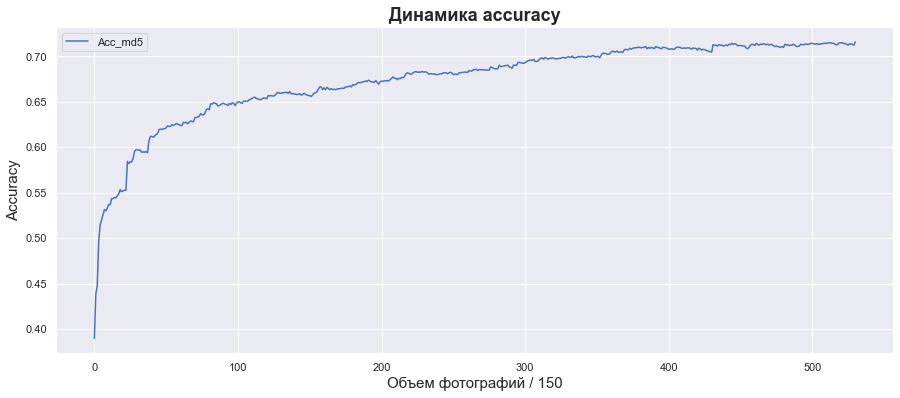

In [42]:
df['Acc_md5'].plot(figsize = (15, 6), label = 'Acc_md5')
#df['Acc_md2'].plot(figsize = (15, 6), label = 'Acc_md2')
#df['D_foto'].plot(figsize = (15, 6))
plt.xlabel('Объем фотографий / 150', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('Динамика accuracy', fontweight = 'bold', fontsize = 18)
plt.legend()

In [43]:
%%time
#Валидация

model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

model = CatBoostClassifier()
#model.load_model('catmodel_vgg19_md2_100_20000.cbm')
#model.load_model('catmodel_vgg19_md1_200_40000.cbm')
model.load_model('catmodel_vgg19_md5.cbm')

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0)
        x = pi_vgg19(x) / 255

        data.append(x)
        target_arr.append(i)

print(f'Predict VGG19')
arrays = model_vgg_19.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data

data_arr = []

for arr in arrays:
    data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Predict Model')
preds = model.predict(X_val, verbose = None)
df['preds'] = preds

print(accuracy_score(preds, Y_val))
CM = confusion_matrix(df['Y_val'], df['preds'])
print(CM)

<timed exec>:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict VGG19
Predict Model
0.665
[[ 22   7  23  29  13  26  28  12]
 [  1 160  47  19   0   9  15   9]
 [  2  27 245  17   4   0   2  23]
 [  5  19  30 147   1   6  17  35]
 [  1   1   6   2 268   1   0   1]
 [  1   2   2   1   1 243   4   6]
 [  1   9  11  10   1   7 146  15]
 [  3  17  49  52   3  13  24  99]]
CPU times: total: 21min 21s
Wall time: 14min 14s


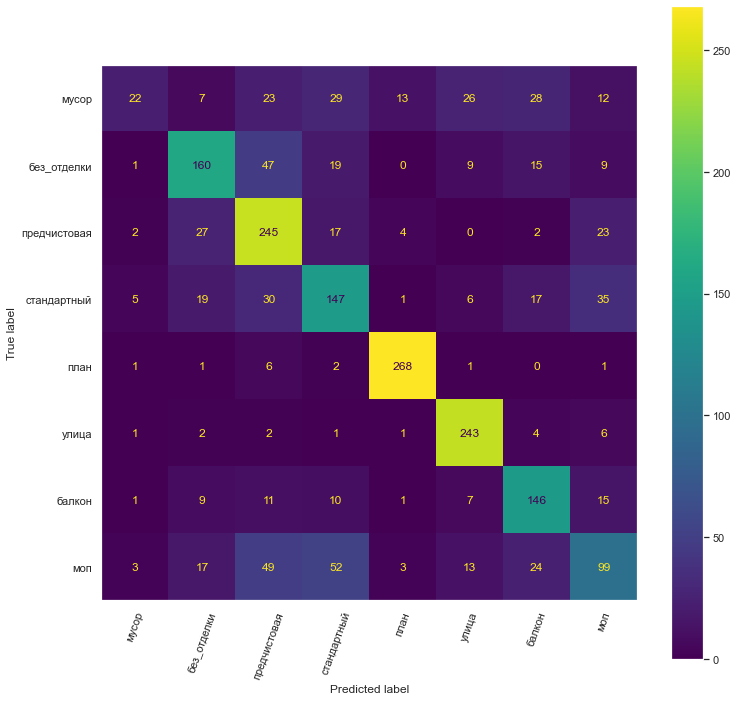

In [44]:
#ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (12, 12))
#ax.grid(False)
disp.plot(values_format = '.3g', ax = ax)
plt.xticks(rotation = 70)
plt.grid(False)
plt.show();

# VGG_19 + CatBoost + AveragePooling2D

In [2]:
%%time
#Валидация

model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0) #отключаем, так как мы предсказываем ниже массив данных, а не 1 значение
        x = pi_vgg19(x) / 255

        data.append(x)
        target_arr.append(i)

print(f'Predict VGG19_AveragePooling2D')
arrays = model_vgg_19.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2)) #уменьшает размерность по окну (2,2) и сохраняет пространственные признаки
features = avg_pool(arrays)
features = features.numpy()

data_arr = []

for arr in features:
    data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Данные для валидации готовы!')

<timed exec>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict VGG19_AveragePooling2D
Данные для валидации готовы!
CPU times: total: 23min 30s
Wall time: 9min 34s


In [ ]:
%%time
#Для предобученной сети
model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

folder_name = [
               'trash',
               'wf', 
               'prefin', 
               #'econ', 
               'stand', 
               #'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ]

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN_8\train'
val_names = os.listdir(val_path) 

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 1000 #количество фото на все классы в 1 batch
h = 0        #шаг

catc = CatBoostClassifier(iterations = 150, #максимальное количество построенных деревьев
                          random_seed = 5, 
                          learning_rate = 0.1, #скорость обучения, определяет насколько быстро или медленно модель 
                                                 #будет учиться
                          max_depth = 5, #глубина дерева, учим на пеньках, чтобы небыло переобучения
                          l2_leaf_reg = 5, #коэффициент при члене регуляризации L2 функции потерь
                          #bagging_temperature = 1,
                          #random_strength = 1,
                          #one_hot_max_size = 8, #не используем one hot encoding, а включаем one_hot_max_size
                          #loss_function = 'Logloss',
                          loss_function = 'MultiClass',
                          eval_metric = 'Accuracy',      #Accuracy
                          use_best_model = True,
                          early_stopping_rounds = 10,
                          #od_type = 'Iter', #если модель переобучилась
                          #od_wait = 5
                          )

#ДЛЯ ПРОДОЛЖЕНИЯ обучения необходимо скорректировать j и подгрузить нашу модель catmodel_vgg19.cbm
#модель выше закоментить
# catc = CatBoostClassifier(iterations = 100, learning_rate = 0.03, max_depth = 10)
# catc.load_model('catmodel_vgg19_md5.cbm')

accuracy = []

for j in tqdm(range(15, 148, 1), position = 0):  #до 148

    data = []        #input array 
    target_arr = []  #output array 

    for n, name_folder in enumerate(val_names):
        class_path = val_path + '\\' + name_folder  #путь к папке первого класса
        img_names = os.listdir(class_path)          #имена фото в папке
        
        foto = int(fotos * class_weights[n])        #количесто фото на класс в зависимости от веса (баланса)
        h = foto * j                                #шаг, который контролирует batchs
        
        #print("\r", end = "") #чистим вывод
        #print(f'j = {j}, h = {h}, n = {n}')        #принтим шаги j и h

        #for img_name in tqdm(img_names, 'Обработанно файлов', position = 0):
        for i in range(0, foto, 1):
        #for i in tqdm(range(0, foto, 1), position = 1): #<---
            img = keras.utils.load_img(class_path + '\\' + img_names[i + h], target_size = (224, 224))
            x = keras.utils.img_to_array(img)
            #x = np.expand_dims(x, axis = 0) #отключил, чтобы не добавлять размерность и полностью передать data_arr в VGG19 для прогноза
            x = pi_vgg19(x) / 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется
            
            data.append(x)
            #data.append(model_vgg_19.predict(x, verbose = None).flatten()) #тут наши факторы вытянутые в массив
            target_arr.append(n)                                            #тут наша метка по классу
    
    print(f'Обучение модели № {j + 1}')
    
    arrays = model_vgg_19.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
    
    avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2)) #уменьшает размерность по окну (2,2) и сохраняет пространственные признаки
    features = avg_pool(arrays)
    features = features.numpy()
    
    data_arr = []
    
    for arr in features:
        data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays)
    
    df_1 = pd.DataFrame(target_arr, columns = ['Y'])
    df_2 = pd.DataFrame(data_arr)
    df = pd.concat([df_1, df_2], axis = 1)
    df = df.sample(frac = 1).reset_index(drop = True)          #перемешиваем строки
    Y = df['Y']
    X = df.drop(['Y'], axis = 1)
    
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
    
    if j == 0:                                                 #если это первый batch, то просто обучаем модель
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr), 
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 #plot = True
                )
        catc.save_model('catmodel_vgg19_md5_avg.cbm')
        pred_val = catc.predict(X_val)
        acc = accuracy_score(pred_val, Y_val)
        accuracy.append(acc)
    
    else:
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr)),    #если это не первый batch, то дообучаем модель
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 #plot = True,
                 init_model = 'catmodel_vgg19_md5_avg.cbm'
                )
        catc.save_model('catmodel_vgg19_md5_avg.cbm')
        cat_model = CatBoostClassifier()
        cat_model.load_model('catmodel_vgg19_md5_avg.cbm')
        pred_val = catc.predict(X_val)
        acc = accuracy_score(pred_val, Y_val)
        accuracy.append(acc)
    
    print(f'Обучение batch № {j + 1} успешно завершено! Accuracy: {acc}')

In [5]:
#Сохраняем в Excel
writer = pd.ExcelWriter('Accuracy_foto.xlsx')
pd.DataFrame(accuracy).to_excel(writer, 'прогноз')
writer.save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_10728\1966282082.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [7]:
df = pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2/Iter.xlsx', sheet_name = 4)
df

,Iter,Acc_md5_avg
0,1,0.4475
1,2,0.4750
2,3,0.5030
3,4,0.5315
4,5,0.5465
...,...,...
135,136,0.7265
136,137,0.7330
137,138,0.7365
138,139,0.7360


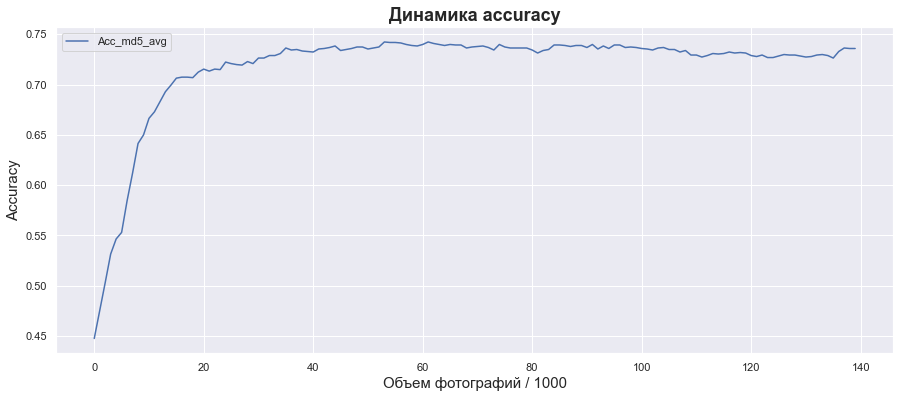

In [9]:
df['Acc_md5_avg'].plot(figsize = (15, 6), label = 'Acc_md5_avg')
#df['Acc_md2'].plot(figsize = (15, 6), label = 'Acc_md2')
#df['D_foto'].plot(figsize = (15, 6))
plt.xlabel('Объем фотографий / 1000', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('Динамика accuracy', fontweight = 'bold', fontsize = 18)
plt.legend()

In [66]:
catc = CatBoostClassifier(iterations = 150, #максимальное количество построенных деревьев
                          random_seed = 5, 
                          learning_rate = 0.1, #скорость обучения, определяет насколько быстро или медленно модель 
                                                 #будет учиться
                          max_depth = 5, #глубина дерева, учим на пеньках, чтобы небыло переобучения
                          l2_leaf_reg = 5, #коэффициент при члене регуляризации L2 функции потерь
                          #bagging_temperature = 1,
                          #random_strength = 1,
                          #one_hot_max_size = 8, #не используем one hot encoding, а включаем one_hot_max_size
                          #loss_function = 'Logloss',
                          loss_function = 'MultiClass',
                          eval_metric = 'Accuracy',      #Accuracy
                          use_best_model = True,
                          early_stopping_rounds = 10,
                          #od_type = 'Iter', #если модель переобучилась
                          #od_wait = 5
                          )

catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr), 
         verbose = False,
         eval_set = (X_val, Y_val),
         plot = True
        )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [54]:
val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN_8\train\4_stand\3_stand.jpg'

img = keras.utils.load_img(val_path, target_size = (224, 224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0) #отключил, чтобы не добавлять размерность и полностью передать data_arr в VGG19 для прогноза
x = pi_vgg19(x) / 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется

dim = model_vgg_19.predict(x, verbose = None)
print('Размерность до avg:', dim.shape)

avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2))
features = avg_pool(dim)
features = features.numpy().flatten()

print('Размерность после avg:', features.shape)

Размерность до avg: (1, 7, 7, 512)
Размерность после avg: (4608,)


In [45]:
# AveragePooling2D
# Входной тензор
input_tensor = tensorflow.random.normal(shape = (1, 10, 10, 3))

# Создаем слой AveragePooling2D
avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2))

# Применяем слой к тензору
output_tensor = avg_pool(input_tensor)

# Вывод
print(f"Входной тензор: {input_tensor.shape}")
print(f"Выходной тензор: {output_tensor.shape}")

Входной тензор: (1, 10, 10, 3)
Выходной тензор: (1, 5, 5, 3)


In [47]:
# GlobalAveragePooling2D
# Входной тензор
input_tensor = tensorflow.random.normal(shape = (1, 10, 10, 3))

# Создаем слой GlobalAveragePooling2D
global_avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D()

# Применяем слой к тензору
output_tensor = global_avg_pool(input_tensor)

# Вывод
print(f"Входной тензор: {input_tensor.shape}")
print(f"Выходной тензор: {output_tensor.shape}")

Входной тензор: (1, 10, 10, 3)
Выходной тензор: (1, 3)


In [10]:
%%time
#Валидация

model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

model = CatBoostClassifier()
model.load_model('catmodel_vgg19_md5_avg.cbm')

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0)
        x = pi_vgg19(x) / 255

        data.append(x)
        target_arr.append(i)

print(f'Predict VGG19_AveragePooling2D')
arrays = model_vgg_19.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data

avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2)) #уменьшает размерность по окну (2,2) и сохраняет пространственные признаки
features = avg_pool(arrays)
features = features.numpy()

data_arr = []

for arr in features:
    data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays)

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Predict Model')
preds = model.predict(X_val, verbose = None)
df['preds'] = preds

print(accuracy_score(preds, Y_val))
CM = confusion_matrix(df['Y_val'], df['preds'])
print(CM)

<timed exec>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict VGG19
Predict Model
0.7075
[[ 43  15  15  29   4  12  15  27]
 [  5 199  29  17   0   1   4   5]
 [  7  45 223  14   0   0   8  23]
 [ 10  12  17 171   0   3   7  40]
 [  4   0   0   1 271   2   0   2]
 [  1   2   1   4   0 244   6   2]
 [  4   8   6  17   0   9 128  28]
 [  8  18  33  48   0   7  10 136]]
CPU times: total: 21min 38s
Wall time: 9min 37s


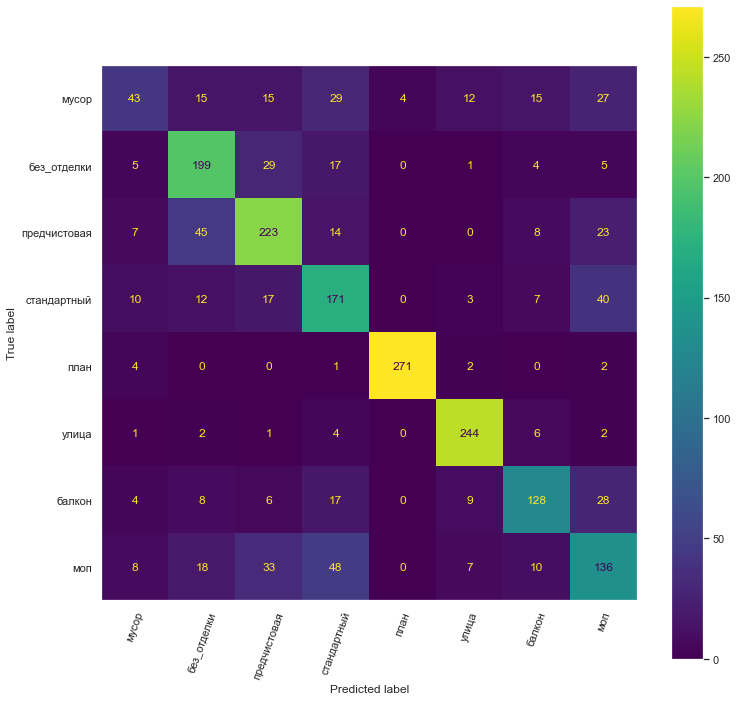

In [11]:
#ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (12, 12))
#ax.grid(False)
disp.plot(values_format = '.3g', ax = ax)
plt.xticks(rotation = 70)
plt.grid(False)
plt.show();

# ResNet152V2 + CatBoost + AveragePooling2D

In [2]:
%%time
#Валидация

model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0) #отключаем, так как мы предсказываем ниже массив данных, а не 1 значение
        x = pi_rnv2(x) #/ 255

        data.append(x)
        target_arr.append(i)

print(f'Predict ResNet152V2_AveragePooling2D')
arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2)) #уменьшает размерность по окну (2,2) и сохраняет пространственные признаки
features = avg_pool(arrays)
features = features.numpy()

data_arr = []

for arr in features:
    data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Данные для валидации готовы!')

<timed exec>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict ResNet152V2_AveragePooling2D
Данные для валидации готовы!
CPU times: total: 10min 53s
Wall time: 8min 13s


In [10]:
%%time
#Для предобученной сети
model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

folder_name = [
               'trash',
               'wf', 
               'prefin', 
               #'econ', 
               'stand', 
               #'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ]

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN_8\train'
val_names = os.listdir(val_path) 

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 200 #количество фото на все классы в 1 batch
h = 0        #шаг

# catc = CatBoostClassifier(iterations = 150, #максимальное количество построенных деревьев
#                           random_seed = 5, 
#                           learning_rate = 0.1, #скорость обучения, определяет насколько быстро или медленно модель 
#                                                  #будет учиться
#                           max_depth = 7, #глубина дерева, учим на пеньках, чтобы небыло переобучения
#                           l2_leaf_reg = 5, #коэффициент при члене регуляризации L2 функции потерь
#                           #bagging_temperature = 1,
#                           #random_strength = 1,
#                           #one_hot_max_size = 8, #не используем one hot encoding, а включаем one_hot_max_size
#                           #loss_function = 'Logloss',
#                           loss_function = 'MultiClass',
#                           eval_metric = 'Accuracy',      #Accuracy
#                           use_best_model = True,
#                           early_stopping_rounds = 40,
#                           #od_type = 'Iter', #если модель переобучилась
#                           #od_wait = 5
#                           )

#ДЛЯ ПРОДОЛЖЕНИЯ обучения необходимо скорректировать j и подгрузить нашу модель catmodel_vgg19.cbm
#модель выше закоментить
# catc = CatBoostClassifier()
catc.load_model('catmodel_rn152v2_md5_avg.cbm') #не все параметры можно изменить при поэтапном обучении, например early_stopping_rounds

accuracy = []

for j in tqdm(range(303, 304, 1), position = 0):  #до 490

    data = []        #input array 
    target_arr = []  #output array 

    for n, name_folder in enumerate(val_names):
        class_path = val_path + '\\' + name_folder  #путь к папке первого класса
        img_names = os.listdir(class_path)          #имена фото в папке
        
        foto = int(fotos * class_weights[n])        #количесто фото на класс в зависимости от веса (баланса)
        h = foto * j                                #шаг, который контролирует batchs
        
        #print("\r", end = "") #чистим вывод
        #print(f'j = {j}, h = {h}, n = {n}')        #принтим шаги j и h

        #for img_name in tqdm(img_names, 'Обработанно файлов', position = 0):
        for i in range(0, foto, 1):
        #for i in tqdm(range(0, foto, 1), position = 1): #<---
            img = keras.utils.load_img(class_path + '\\' + img_names[i + h], target_size = (224, 224))
            x = keras.utils.img_to_array(img)
            #x = np.expand_dims(x, axis = 0) #отключил, чтобы не добавлять размерность и полностью передать data_arr в VGG19 для прогноза
            x = pi_rnv2(x) #/ 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется
            
            data.append(x)
            #data.append(model_vgg_19.predict(x, verbose = None).flatten()) #тут наши факторы вытянутые в массив
            target_arr.append(n)                                            #тут наша метка по классу
    
    print(f'Обучение модели № {j + 1}')
    
    arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
    
    avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2)) #уменьшает размерность по окну (2,2) и сохраняет пространственные признаки
    features = avg_pool(arrays)
    features = features.numpy()
    
    data_arr = []
    
    for arr in features:
        data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays)
    
    df_1 = pd.DataFrame(target_arr, columns = ['Y'])
    df_2 = pd.DataFrame(data_arr)
    df = pd.concat([df_1, df_2], axis = 1)
    df = df.sample(frac = 1).reset_index(drop = True)          #перемешиваем строки
    Y = df['Y']
    X = df.drop(['Y'], axis = 1)
    
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
    
    if j == 0:                                                 #если это первый batch, то просто обучаем модель
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr), 
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 #plot = True
                )
        catc.save_model('catmodel_rn152v2_md5_avg.cbm')
        pred_val = catc.predict(X_val)
        acc = accuracy_score(pred_val, Y_val)
        accuracy.append(acc)
    
    else:
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr)),    #если это не первый batch, то дообучаем модель
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 plot = True,
                 init_model = 'catmodel_rn152v2_md5_avg.cbm'
                )
        catc.save_model('catmodel_rn152v2_md5_avg.cbm')
        cat_model = CatBoostClassifier()
        cat_model.load_model('catmodel_rn152v2_md5_avg.cbm')
        pred_val = catc.predict(X_val)
        acc = accuracy_score(pred_val, Y_val)
        accuracy.append(acc)
    
    print(f'Обучение batch № {j + 1} успешно завершено! Accuracy: {acc}')

<timed exec>:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1 [00:00<?, ?it/s]

Обучение модели № 304


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Обучение batch № 304 успешно завершено! Accuracy: 0.749
CPU times: total: 2min 12s
Wall time: 1min 37s


In [66]:
catc = CatBoostClassifier(iterations = 150, #максимальное количество построенных деревьев
                          random_seed = 5, 
                          learning_rate = 0.1, #скорость обучения, определяет насколько быстро или медленно модель 
                                                 #будет учиться
                          max_depth = 5, #глубина дерева, учим на пеньках, чтобы небыло переобучения
                          l2_leaf_reg = 5, #коэффициент при члене регуляризации L2 функции потерь
                          #bagging_temperature = 1,
                          #random_strength = 1,
                          #one_hot_max_size = 8, #не используем one hot encoding, а включаем one_hot_max_size
                          #loss_function = 'Logloss',
                          loss_function = 'MultiClass',
                          eval_metric = 'Accuracy',      #Accuracy
                          use_best_model = True,
                          early_stopping_rounds = 10,
                          #od_type = 'Iter', #если модель переобучилась
                          #od_wait = 5
                          )

catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr), 
         verbose = False,
         eval_set = (X_val, Y_val),
         plot = True
        )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [6]:
#Сохраняем в Excel
writer = pd.ExcelWriter('Accuracy_foto.xlsx')
pd.DataFrame(accuracy).to_excel(writer, 'прогноз')
writer.save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_1876\1966282082.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [13]:
df = pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2/Iter.xlsx', sheet_name = 5)
#df

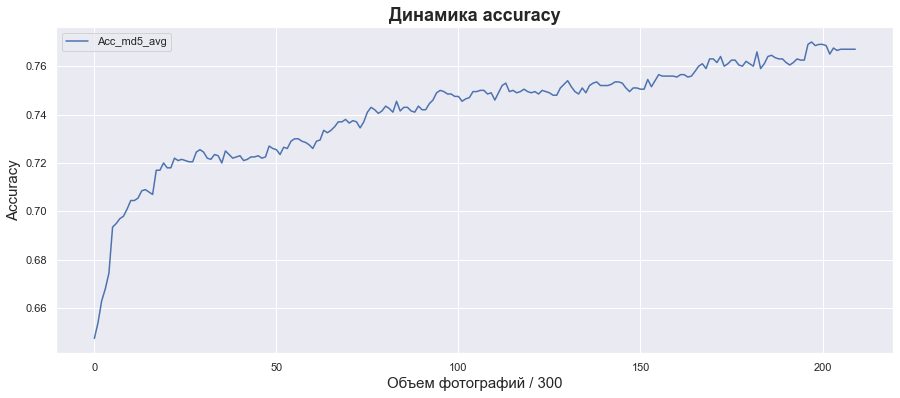

In [15]:
df['Acc_md5_avg'].plot(figsize = (15, 6), label = 'Acc_md5_avg')
#df['Acc_md2'].plot(figsize = (15, 6), label = 'Acc_md2')
#df['D_foto'].plot(figsize = (15, 6))
plt.xlabel('Объем фотографий / 300', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('Динамика accuracy', fontweight = 'bold', fontsize = 18)
plt.legend()

In [54]:
val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN_8\train\4_stand\3_stand.jpg'

img = keras.utils.load_img(val_path, target_size = (224, 224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0) #отключил, чтобы не добавлять размерность и полностью передать data_arr в VGG19 для прогноза
x = pi_vgg19(x) / 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется

dim = model_vgg_19.predict(x, verbose = None)
print('Размерность до avg:', dim.shape)

avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2))
features = avg_pool(dim)
features = features.numpy().flatten()

print('Размерность после avg:', features.shape)

Размерность до avg: (1, 7, 7, 512)
Размерность после avg: (4608,)


In [45]:
# AveragePooling2D
# Входной тензор
input_tensor = tensorflow.random.normal(shape = (1, 10, 10, 3))

# Создаем слой AveragePooling2D
avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2))

# Применяем слой к тензору
output_tensor = avg_pool(input_tensor)

# Вывод
print(f"Входной тензор: {input_tensor.shape}")
print(f"Выходной тензор: {output_tensor.shape}")

Входной тензор: (1, 10, 10, 3)
Выходной тензор: (1, 5, 5, 3)


In [47]:
# GlobalAveragePooling2D
# Входной тензор
input_tensor = tensorflow.random.normal(shape = (1, 10, 10, 3))

# Создаем слой GlobalAveragePooling2D
global_avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D()

# Применяем слой к тензору
output_tensor = global_avg_pool(input_tensor)

# Вывод
print(f"Входной тензор: {input_tensor.shape}")
print(f"Выходной тензор: {output_tensor.shape}")

Входной тензор: (1, 10, 10, 3)
Выходной тензор: (1, 3)


In [16]:
%%time
#Валидация

model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

model = CatBoostClassifier()
model.load_model('catmodel_rn152v2_md5_avg.cbm')

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0)
        x = pi_rnv2(x) #/ 255

        data.append(x)
        target_arr.append(i)

print(f'Predict ResNet152V2_AveragePooling2D')
arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
avg_pool = tensorflow.keras.layers.AveragePooling2D(pool_size = (2, 2)) #уменьшает размерность по окну (2,2) и сохраняет пространственные признаки
features = avg_pool(arrays)
features = features.numpy()

data_arr = []

for arr in features:
    data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays)

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Predict Model')
preds = model.predict(X_val, verbose = None)
df['preds'] = preds

print(accuracy_score(preds, Y_val))
CM = confusion_matrix(df['Y_val'], df['preds'])
print(CM)

<timed exec>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict ResNet152V2_AveragePooling2D
Predict Model
0.751
[[ 64   3  11  29   3   6  16  28]
 [  6 187  44   3   0   0  17   3]
 [  6  27 257  12   0   0   5  13]
 [ 14   4  18 178   0   0   7  39]
 [  1   0   0   2 276   1   0   0]
 [  7   1   0   0   1 240   7   4]
 [  5  17   8  15   0   5 135  15]
 [ 11  10  23  37   0   0  14 165]]
CPU times: total: 10min 5s
Wall time: 14min 17s


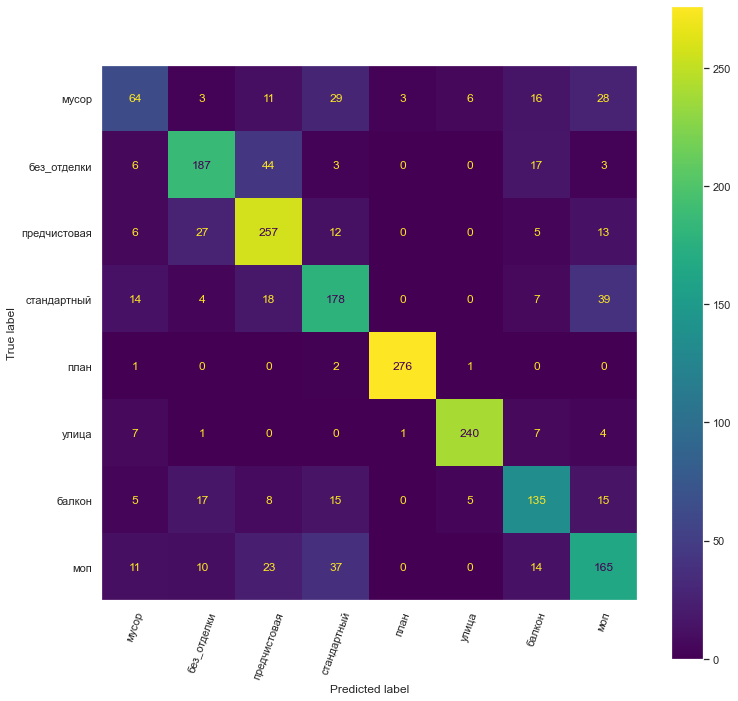

In [17]:
#ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (12, 12))
#ax.grid(False)
disp.plot(values_format = '.3g', ax = ax)
plt.xticks(rotation = 70)
plt.grid(False)
plt.show();

# ResNet152V2 + CatBoost + GlobalAveragePooling2D

In [2]:
%%time
#Валидация

model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0) #отключаем, так как мы предсказываем ниже массив данных, а не 1 значение
        x = pi_rnv2(x) #/ 255

        data.append(x)
        target_arr.append(i)

print(f'Predict ResNet152V2_GlobalAveragePooling2D')
arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
features = avg_pool(arrays)
data_arr = features.numpy()

# data_arr = []

# for arr in features:
#     data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Данные для валидации готовы!')

<timed exec>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict ResNet152V2_GlobalAveragePooling2D
Данные для валидации готовы!
CPU times: total: 13min 7s
Wall time: 9min 49s


In [ ]:
%%time
#Для предобученной сети
model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

folder_name = [
               'trash',
               'wf', 
               'prefin', 
               #'econ', 
               'stand', 
               #'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ]

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN_8\train'
val_names = os.listdir(val_path) 

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2500 #количество фото на все классы в 1 batch
h = 0        #шаг

catc = CatBoostClassifier(iterations = 200, #максимальное количество построенных деревьев
                          random_seed = 5, 
                          learning_rate = 0.1, #скорость обучения, определяет насколько быстро или медленно модель 
                                                 #будет учиться
                          max_depth = 7, #глубина дерева, учим на пеньках, чтобы небыло переобучения
                          l2_leaf_reg = 5, #коэффициент при члене регуляризации L2 функции потерь
                          #bagging_temperature = 1,
                          #random_strength = 1,
                          #one_hot_max_size = 8, #не используем one hot encoding, а включаем one_hot_max_size
                          #loss_function = 'Logloss',
                          loss_function = 'MultiClass',
                          eval_metric = 'Accuracy',      #Accuracy
                          use_best_model = True,
                          early_stopping_rounds = 40,
                          #od_type = 'Iter', #если модель переобучилась
                          #od_wait = 5
                          )

#ДЛЯ ПРОДОЛЖЕНИЯ обучения необходимо скорректировать j и подгрузить нашу модель catmodel_vgg19.cbm
#модель выше закоментить
# catc = CatBoostClassifier()
# catc.load_model('catmodel_rn152v2_md5_avg.cbm') #не все параметры можно изменить при поэтапном обучении, например early_stopping_rounds

accuracy = []

for j in tqdm(range(0, 65, 1), position = 0):  #до 66

    data = []        #input array 
    target_arr = []  #output array 

    for n, name_folder in enumerate(val_names):
        class_path = val_path + '\\' + name_folder  #путь к папке первого класса
        img_names = os.listdir(class_path)          #имена фото в папке
        
        foto = int(fotos * class_weights[n])        #количесто фото на класс в зависимости от веса (баланса)
        h = foto * j                                #шаг, который контролирует batchs
        
        #print("\r", end = "") #чистим вывод
        #print(f'j = {j}, h = {h}, n = {n}')        #принтим шаги j и h

        #for img_name in tqdm(img_names, 'Обработанно файлов', position = 0):
        for i in range(0, foto, 1):
        #for i in tqdm(range(0, foto, 1), position = 1): #<---
            img = keras.utils.load_img(class_path + '\\' + img_names[i + h], target_size = (224, 224))
            x = keras.utils.img_to_array(img)
            #x = np.expand_dims(x, axis = 0) #отключил, чтобы не добавлять размерность и полностью передать data_arr в VGG19 для прогноза
            x = pi_rnv2(x) #/ 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется
            
            data.append(x)
            #data.append(model_vgg_19.predict(x, verbose = None).flatten()) #тут наши факторы вытянутые в массив
            target_arr.append(n)                                            #тут наша метка по классу
    
    print(f'Обучение модели № {j + 1}')
    
    arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data

    avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
    features = avg_pool(arrays)
    data_arr = features.numpy()

    
#     data_arr = []
    
#     for arr in features:
#         data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays)
    
    df_1 = pd.DataFrame(target_arr, columns = ['Y'])
    df_2 = pd.DataFrame(data_arr)
    df = pd.concat([df_1, df_2], axis = 1)
    df = df.sample(frac = 1).reset_index(drop = True)          #перемешиваем строки
    Y = df['Y']
    X = df.drop(['Y'], axis = 1)
    
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
    
    if j == 0:                                                 #если это первый batch, то просто обучаем модель
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr), 
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 #plot = True
                )
        catc.save_model('catmodel_rn152v2_md5_gap.cbm')
        
        pred_val = catc.predict(X_val)
        acc_val = accuracy_score(pred_val, Y_val)
        
        pred_train = catc.predict(X)
        acc_train = accuracy_score(pred_train, Y)
        
        accuracy.append(acc_val)
    
    else:
        catc.fit(X, Y,
        #catc.fit(np.array(data_arr), np.array(target_arr)),    #если это не первый batch, то дообучаем модель
                 verbose = False,
                 eval_set = (X_val, Y_val),
                 #plot = True,
                 init_model = 'catmodel_rn152v2_md5_gap.cbm'
                )
        catc.save_model('catmodel_rn152v2_md5_gap.cbm')
        
        cat_model = CatBoostClassifier()
        cat_model.load_model('catmodel_rn152v2_md5_gap.cbm')
        
        pred_val = catc.predict(X_val)
        acc_val = accuracy_score(pred_val, Y_val)
        
        pred_train = catc.predict(X)
        acc_train = accuracy_score(pred_train, Y)
        
        accuracy.append(acc_val)
    
    print(f'Обучение batch № {j + 1} успешно завершено! Accuracy_val: {acc_val}, Accuracy_train: {acc_train}')

In [6]:
#Сохраняем в Excel
writer = pd.ExcelWriter('Accuracy_foto.xlsx')
pd.DataFrame(accuracy).to_excel(writer, 'прогноз')
writer.save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_18596\1966282082.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [10]:
df = pd.read_excel('D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2/Iter.xlsx', sheet_name = 7)
#df

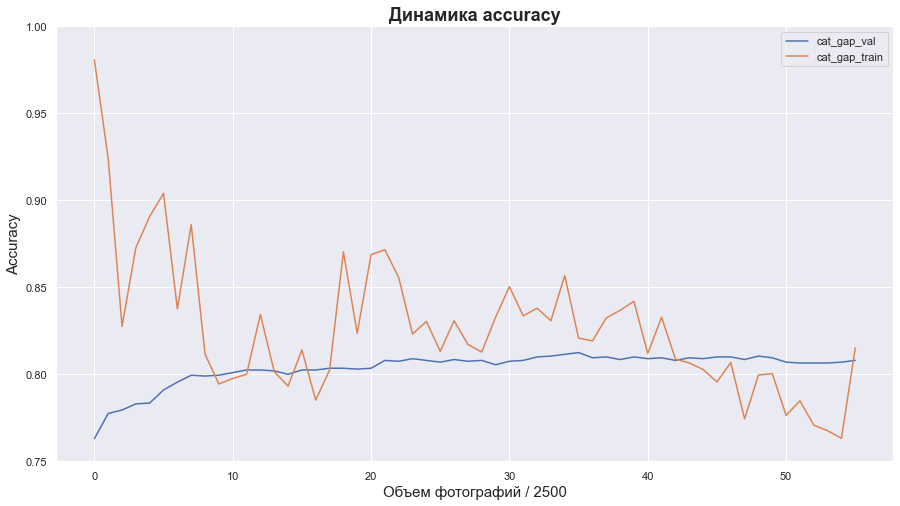

In [14]:
df['cat_gap_val'].plot(figsize = (15, 8), label = 'cat_gap_val')
df['cat_gap_train'].plot(figsize = (15, 8), label = 'cat_gap_train')
#df['D_foto'].plot(figsize = (15, 6))
plt.xlabel('Объем фотографий / 2500', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim(0.75, 1)
plt.title('Динамика accuracy', fontweight = 'bold', fontsize = 18)
plt.legend()

In [15]:
%%time
#тест

model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

model = CatBoostClassifier()
model.load_model('catmodel_rn152v2_md5_gap.cbm')

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

class_weights = [0.08, 0.13, 0.16, 0.13, 0.14, 0.13, 0.10, 0.13] #веса для классов

fotos = 2000 #количество фото на все классы

data = []        #input array 
target_arr = []  #output array 

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    foto = int(fotos * class_weights[i])            #количесто фото на класс в зависимости от веса (баланса)
    img_names = random.sample(img_names, k = foto)  #случайный набор фото из папки класса name в размере доли k
    
    for img_name in img_names:
    #for img_name in tqdm(img_names, 'Обработано', position = 0):
    #for i in range(0, foto, 1):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        #x = np.expand_dims(x, axis = 0) #отключаем, так как мы предсказываем ниже массив данных, а не 1 значение
        x = pi_rnv2(x) #/ 255

        data.append(x)
        target_arr.append(i)

print(f'Predict ResNet152V2_GlobalAveragePooling2D')
arrays = model_rn152v2.predict(np.array(data), verbose = None) #делаем предсказания по всему массиву data
avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
features = avg_pool(arrays)
data_arr = features.numpy()

# data_arr = []

# for arr in features:
#     data_arr.append(arr.flatten()) #вытягиваем каждый прогноз VGG19 (arrays) в длину 25088 значений

df_1 = pd.DataFrame(target_arr, columns = ['Y_val'])
df_2 = pd.DataFrame(data_arr)
df = pd.concat([df_1, df_2], axis = 1)
Y_val = df['Y_val']
X_val = df.drop(['Y_val'], axis = 1)

print(f'Predict Model')
preds = model.predict(X_val, verbose = None)
df['preds'] = preds

print(accuracy_score(preds, Y_val))
CM = confusion_matrix(df['Y_val'], df['preds'])
print(CM)

<timed exec>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Обработано: 0it [00:00, ?it/s]

Predict ResNet152V2_GlobalAveragePooling2D
Predict Model
0.8055
[[ 69  11  14  35   1   6  12  12]
 [  1 214  35   0   0   1   6   3]
 [  4  31 259  11   0   0   3  12]
 [ 10   3   8 205   0   2   4  28]
 [  2   0   0   2 276   0   0   0]
 [  2   1   0   1   0 249   3   4]
 [  7  18   6   8   0   8 144   9]
 [  8  10   9  27   0   1  10 195]]
CPU times: total: 10min 39s
Wall time: 12min 42s


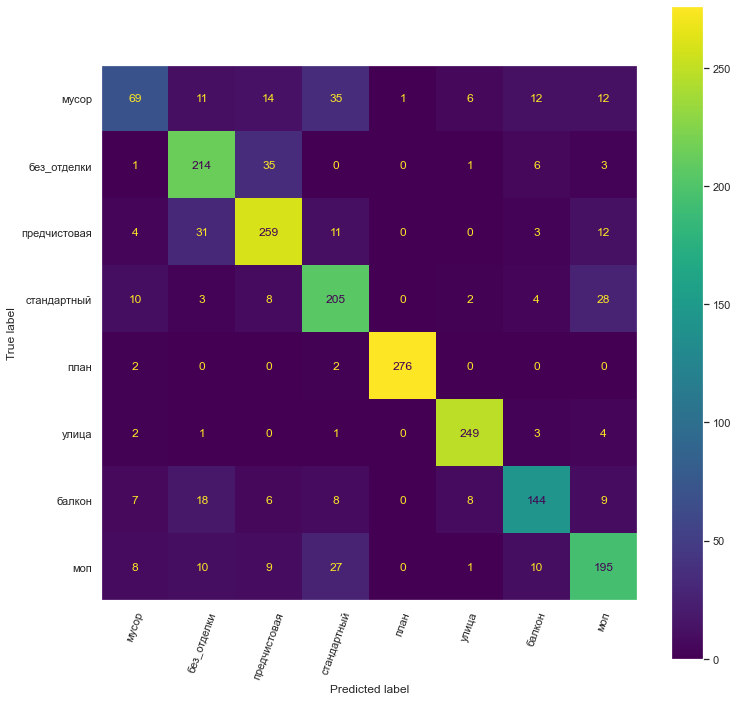

In [16]:
#ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (12, 12))
#ax.grid(False)
disp.plot(values_format = '.4g', ax = ax)
plt.xticks(rotation = 70)
plt.grid(False)
plt.show();

In [18]:
#classification_report
print("\nClassification Report : ")
print(classification_report(df['Y_val'], df['preds'], target_names = classes))


Classification Report : 
              precision    recall  f1-score   support

       мусор       0.67      0.43      0.52       160
 без_отделки       0.74      0.82      0.78       260
предчистовая       0.78      0.81      0.80       320
 стандартный       0.71      0.79      0.75       260
        план       1.00      0.99      0.99       280
       улица       0.93      0.96      0.94       260
      балкон       0.79      0.72      0.75       200
         моп       0.74      0.75      0.75       260

    accuracy                           0.81      2000
   macro avg       0.80      0.78      0.79      2000
weighted avg       0.80      0.81      0.80      2000



In [3]:
model_rn152v2 = ResNet152V2(
                            weights = 'imagenet', 
                            include_top = False
                            )

model = CatBoostClassifier()
model.load_model('catmodel_rn152v2_md5_gap.cbm')

classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           #'экономный', 
           'стандартный', 
           #'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

img_trash_all = []
img_wf_all = []
img_prefin_all = []
img_stand_all = []
img_plan_all = []
img_street_all = []
img_balc_all = []
img_mop_all = []

val_path = "D:\\Стас\\Ученье - Свет\\Оценка\\Аспирантура\\Видео по NN, Data mining, ABC и т.д\\Распределение Гаусса, регрессия\\Python\\!Наработки\\Отделка_2\\NN\\split_NN_8\\val"
val_names = os.listdir(val_path)

for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name
    img_names = os.listdir(class_path)
    
    for img_name in tqdm(img_names, 'Обработано', position = 0):
        img_i = image.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = image.img_to_array(img_i)
        x = np.expand_dims(x, axis = 0)
        x = pi_rnv2(x) #/ 255
        
        pr_rn152v2 = model_rn152v2.predict(x, verbose = None)       #делаем предсказание
        avg_pool = tensorflow.keras.layers.GlobalAveragePooling2D() #уменьшает размерность глобально
        feature = avg_pool(pr_rn152v2).numpy()
        
        preds = model.predict(feature, verbose = None)
        pr = {'Predict': preds[0][0], 'Class_name': classes[i], 'True': i, 'Foto_name': img_name}
        
        if i == 0:
            img_trash_all.append(pr)
        elif i == 1:
            img_wf_all.append(pr)
        elif i == 2:
            img_prefin_all.append(pr)
        elif i == 3:
            img_stand_all.append(pr)
        elif i == 4:
            img_plan_all.append(pr)
        elif i == 5:
            img_street_all.append(pr)
        elif i == 6:
            img_balc_all.append(pr)
        else:
            img_mop_all.append(pr)


df_trash = pd.DataFrame(img_trash_all)
df_wf = pd.DataFrame(img_wf_all)
df_prefin = pd.DataFrame(img_prefin_all)
df_stand = pd.DataFrame(img_stand_all)
df_plan = pd.DataFrame(img_plan_all)
df_street = pd.DataFrame(img_street_all)
df_balc = pd.DataFrame(img_balc_all)
df_mop = pd.DataFrame(img_mop_all)

df_all = pd.concat([df_trash, df_wf, df_prefin, df_stand, df_plan, df_street, df_balc, df_mop])
CM = confusion_matrix(df_all['True'], df_all['Predict'])
print(CM)

C:\Users\skapr\AppData\Local\Temp\ipykernel_18344\3790589502.py:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, name in tqdm(enumerate(val_names), 'Обработано', position = 0):


Обработано: 0it [00:00, ?it/s]

C:\Users\skapr\AppData\Local\Temp\ipykernel_18344\3790589502.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img_name in tqdm(img_names, 'Обработано', position = 0):


Обработано:   0%|          | 0/553 [00:00<?, ?it/s]

Обработано:   0%|          | 0/3689 [00:00<?, ?it/s]

Обработано:   0%|          | 0/4619 [00:00<?, ?it/s]

Обработано:   0%|          | 0/3947 [00:00<?, ?it/s]

Обработано:   0%|          | 0/4250 [00:00<?, ?it/s]

Обработано:   0%|          | 0/7564 [00:00<?, ?it/s]

Обработано:   0%|          | 0/1166 [00:00<?, ?it/s]

Обработано:   0%|          | 0/2742 [00:00<?, ?it/s]

[[ 248   24   33  100    7   29   48   64]
 [  22 3033  441   40    2   11   99   41]
 [  46  429 3842  123    0    0   51  128]
 [ 177   74  109 3049    0   11  106  421]
 [  16    0    0    7 4209   16    0    2]
 [ 104   51    3   11    6 7158  154   77]
 [  36   90   27   60    0   38  856   59]
 [  79   88  151  307    0   26   90 2001]]


In [4]:
from sklearn.metrics import accuracy_score

print(accuracy_score(df_all['Predict'], df_all['True']))

0.8550998948475289


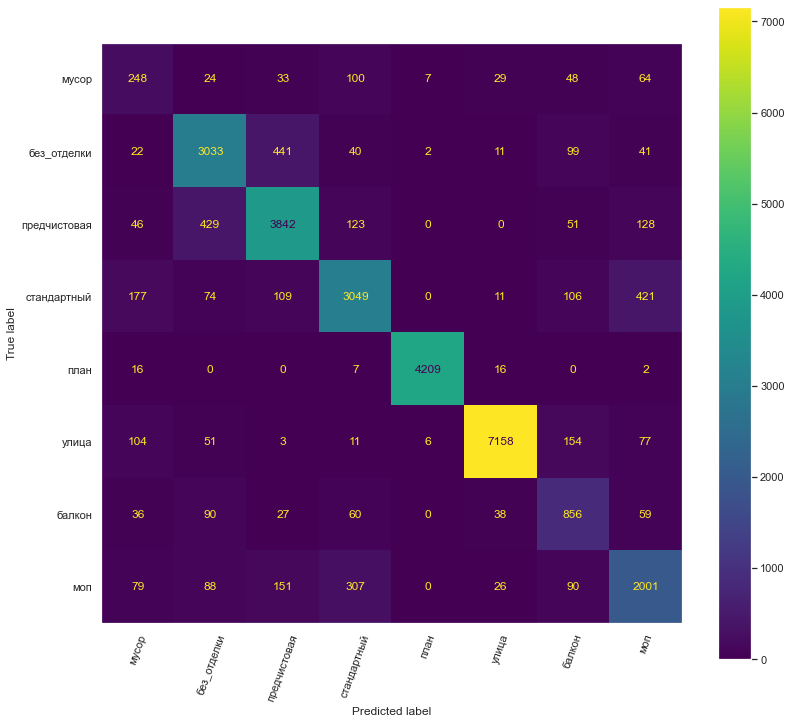

In [5]:
#ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (13, 12))
disp.plot(values_format = '.6g', ax = ax)
plt.xticks(rotation = 70)
plt.grid(False)
plt.show();

In [6]:
#classification_report
print("\nClassification Report : ")
print(classification_report(df_all['True'], df_all['Predict'], target_names = classes))


Classification Report : 
              precision    recall  f1-score   support

       мусор       0.34      0.45      0.39       553
 без_отделки       0.80      0.82      0.81      3689
предчистовая       0.83      0.83      0.83      4619
 стандартный       0.82      0.77      0.80      3947
        план       1.00      0.99      0.99      4250
       улица       0.98      0.95      0.96      7564
      балкон       0.61      0.73      0.67      1166
         моп       0.72      0.73      0.72      2742

    accuracy                           0.86     28530
   macro avg       0.76      0.78      0.77     28530
weighted avg       0.86      0.86      0.86     28530



In [7]:
#Сохраняем в Excel
writer = pd.ExcelWriter('Классификация_фото.xlsx')
df_all.to_excel(writer, 'прогноз')
writer.save()

C:\Users\skapr\AppData\Local\Temp\ipykernel_18344\2755980286.py:4: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [ ]:
model1 = CatBoostRegressor(**params)
batch1 = Pool(train_data1, label=train_labels1)
model1.fit(X=batch1)

# continue training with different portion of data

model2 = CatBoostRegressor(**params)
batch2 = Pool(train_data2, label=train_labels2)
batch2.set_baseline(model1.predict(batch2))
model2.fit(X=batch2)

# build resulting model

model = sum_models([model1, model2])


y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

categorical_features_indices = np.where(X.dtypes != np.float)[0]

X_train, X_validation, y_train, y_validation = train_test_split(X, 
                                                                y, 
                                                                train_size=0.8, 
                                                                random_state=42)

train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=categorical_features_indices)
validate_pool = Pool(X_validation, 
                     y_validation, 
                     cat_features=categorical_features_indices)

models = []
for i in range(5):
    model = CatBoostClassifier(iterations=100, 
                               random_seed=i)
    model.fit(train_pool, 
              eval_set=validate_pool)
    models.append(model)

models_avrg = sum_models(models, 
                         weights=[1.0/len(models)] * len(models))

# MobileNetV2 + CatBoost

In [6]:
#Смотрим размер выходного (последнего) тензора
from tensorflow.keras.applications import Xception

model = Xception(weights = 'imagenet', include_top = False, input_shape = (299, 299, 3))

input_image = tensorflow.random.normal((1, 299, 299, 3))
output = model(input_image)

print(output.shape)
print(output.shape[1] * output.shape[2] * output.shape[3])

(1, 10, 10, 2048)
204800


In [ ]:
%%time
#Для предобученной сети
model_mobv2 = MobileNetV2(
                          weights = 'imagenet', 
                          include_top = False
                          )

folder_name = [
               'trash',
               'wf', 
               'prefin', 
               'econ', 
               'stand', 
               'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ]

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN\train'
val_names = os.listdir(val_path) 

class_weights = [0.08, 0.11, 0.13, 0.07, 0.11, 0.08, 0.12, 0.11, 0.08, 0.11] #веса для классов

fotos = 500 #количество фото на все классы в 1 batch
h = 0       #шаг, после остановки модели и ее продолжении необходимо изменить h. Для следующих 100 итераций h = 

catc =  CatBoostClassifier(iterations = 200, #максимальное количество построенных деревьев
                           random_seed = 5, 
                           learning_rate = 0.02, #скорость обучения, определяет насколько быстро или медленно модель 
                                                 #будет учиться
                           max_depth = 5, #глубина дерева
                           #l2_leaf_reg=20, #коэффициент при члене регуляризации L2 функции потерь
                           #bagging_temperature=1,
                           #random_strength=1,
                           #one_hot_max_size=8, #не используем one hot encoding, а включаем one_hot_max_size
                           #loss_function = 'Logloss',
                           loss_function = 'MultiClass',
                           #eval_metric = 'Accuracy',
                           od_type = 'Iter', #если модель переобучилась
                           od_wait = 20
                          )

for j in tqdm(range(0, 10, 1), position = 0):  #1 итерация = 500 фото по всем классам

    data_arr = []        #input array 
    target_arr = []      #output array 

    for n, name_folder in enumerate(val_names):
        class_path = val_path + '\\' + name_folder  #путь к папке первого класса
        img_names = os.listdir(class_path)          #имена фото в папке
        
        foto = int(fotos * class_weights[n])        #количесто фото на класс в зависимости от веса (баланса)
        h = foto * j                                #шаг, который контролирует batchs
        
        #print("\r", end = "") #чистим вывод
        #print(f'j = {j}, h = {h}, n = {n}')        #принтим шаги j и h

        #for img_name in tqdm(img_names, 'Обработанно файлов', position = 0):
        for i in tqdm(range(0, foto, 1), position = 1):
            img = keras.utils.load_img(class_path + '\\' + img_names[i + h], target_size = (224, 224))
            x = keras.utils.img_to_array(img)
            x = np.expand_dims(x, axis = 0)
            x = pi_vgg19(x) / 255  #в некоторых случаях необходимо делить на 255, согласно док vgg19 не масштабируется
            data_arr.append(model_vgg_19.predict(x, verbose = None).flatten()) #тут наши факторы вытянутые в массив
            target_arr.append(n)                                                 #тут наша метка по классу
    
    print('Обучение модели...')
    
    if j == 0:                                                 #если это первый batch, то просто обучаем модель
        catc.fit(np.array(data_arr), np.array(target_arr), 
                 verbose = False 
                )
    else: 
        catc.fit(np.array(data_arr), np.array(target_arr),    #если это не первый batch, то дообучаем модель
                 verbose = False,
                 init_model = 'catmodel_vgg19.cbm'
                )

    catb.save_model('catmodel_vgg19.cbm')
    
    print(f'Обучение batch № {j + 1} успешно завершено!')

In [53]:
model_vgg_19 = VGG19(
                     weights = 'imagenet', 
                     include_top = False
                     )

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN\train\1_wf\17_wf.jpg'
img = keras.utils.load_img(val_path, target_size = (224, 224))
x = keras.utils.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = pi_vgg19(x) / 255

fut = model_vgg_19.predict(x).flatten()
fut

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step


# Для алгоритмов

In [ ]:
#Для алгоритма
folder_name = [
               'trash',
               'wf', 
               'prefin', 
               'econ', 
               'stand', 
               'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ] 

err_f = []
data_arr = []        #input array 
target_arr = []      #output array
#data = []

#csv = open(r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\data.csv', "w")

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN\split_NN\train'
val_names = os.listdir(val_path) 

for i, name_folder in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name_folder
    img_names = os.listdir(class_path)

    for img_name in tqdm(img_names, 'Обработанно файлов', position = 0):
        try:
            img_array = imread(class_path + '\\' + img_name)                        #на выходе массив numpy
            img_resized = resize(img_array, (224, 314, 3))                          #изменяем размер фото (высота, ширина)

            #img = keras.utils.load_img(class_path + '\\' + img_name, target_size = (224, 314))
            #x = keras.utils.img_to_array(img)
            #x = img_resized.flatten() / 255

            data_arr.append(img_resized.flatten())                                  #вытягиваем
            #data_arr.append(x)                                                     #вытягиваем
            target_arr.append(i)
            #data.append([i, list(img_resized.flatten())])

        except:
            err_aug.append(img_name)
    
    print(f'Loaded category: {folder_name[i]} successfully') 

#data = np.array(data_arr) 
#target = np.array(target_arr)

# Для предобученной сети

In [ ]:
#Для предобученной сети
model_res = ResNet152V2(
                        weights = 'imagenet', 
                        include_top = False
                       )

folder_name = [
               'trash',
               'wf', 
               'prefin', 
               'econ', 
               'stand', 
               'imp', 
               'plan', 
               'street', 
               'balc', 
               'mop'
              ]

data_arr = []        #input array 
target_arr = []      #output array 

val_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN'
val_names = os.listdir(val_path) 

for i, name_folder in tqdm(enumerate(val_names), 'Обработано', position = 0):
    class_path = val_path + '\\' + name_folder
    img_names = os.listdir(class_path)

    for img_name in tqdm(img_names, 'Обработанно файлов', position = 0): 
        img = keras.utils.load_img(class_path + '\\' + img_name, target_size = (224, 224))
        x = keras.utils.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        x = preprocess_input(x) #/ 255  #в некоторых случаях необходимо делить на 255, согласно док resnet_v2 преобразует в диапазон от -1 до 1
        #x = x / 255
        #features = model.predict(x)
        data_arr.append(model_res.predict(x))
        target_arr.append(i)
    
    print(f'loaded category: {folder_name[i]} successfully')

data = np.array(data_arr) 
target = np.array(target_arr)

In [ ]:
classes = [
           'мусор',
           'без_отделки', 
           'предчистовая', 
           'экономный', 
           'стандартный', 
           'улучшенный', 
           'план', 
           'улица', 
           'балкон', 
           'моп'
          ]

In [ ]:
df = pd.DataFrame(data)
df['Target'] = target 
df.shape

In [ ]:
X = df.iloc[:, : -1]  
Y = df.iloc[:, -1]

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

In [ ]:
model = Sequential()
model.add(Flatten())
#model.add(GlobalAveragePooling2D())
#model.add(Dense(512, activation = 'relu'))
#model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
#model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', #у нас более 2-х классов
              optimizer = 'adam',
              metrics = ['accuracy']
             )

In [ ]:
model_checkpoint = callbacks.ModelCheckpoint(filepath = 'model_best_{epoch}.keras',
                                             monitor = 'val_loss',
                                             verbose = 1,
                                             save_best_only = True,
                                             save_weights_only = False,
                                             mode = 'auto',
                                             save_freq = 'epoch'
                                             )

In [ ]:
early_stop = callbacks.EarlyStopping(monitor = 'val_loss',
                                     min_delta = 0,
                                     patience = 3,
                                     verbose = 1,
                                     mode = 'auto',
                                     #baseline = 0.006,
                                     restore_best_weights = True
                                     )

In [ ]:
hist = model.fit(
                 X_train,
                 Y_train,
                 validation_data = (X_test, Y_test),
                 batch_size = 32,
                 epochs = 10,
                 callbacks = [model_checkpoint, early_stop]
                )

In [ ]:
#model.save('trained_model.h5')

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

tab_res = pd.DataFrame({'accuracy': acc, 'val_accuracy': val_acc, 'loss': loss, 'val_loss': val_loss})
tab_res

In [ ]:
# Считаем графики Accuracy
plt.figure(figsize = (10, 7))

plt.plot(hist.history['accuracy'], 
         label='Accuracy')
plt.plot(hist.history['val_accuracy'], 
         label='Val_Accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Считаем графики потери
plt.figure(figsize = (10, 7))

plt.plot(hist.history['loss'], 
         label='loss')
plt.plot(hist.history['val_loss'], 
         label='Val_loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

print("Train score:", accuracy_score(pred_train, Y_train))
print("Test score:", accuracy_score(pred_test, Y_test))

#print(xgbc.feature_importances_)
print("\nClassification Report : ")
print(classification_report(Y_test, pred_test, target_names = classes))

In [ ]:
CM = confusion_matrix(Y_test, pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix = CM, display_labels = classes)

fig, ax = plt.subplots(figsize = (10, 10))
disp.plot(values_format = '.3g', ax = ax)
plt.xticks(rotation = 70)
plt.show();

# Incremental Learning

In [ ]:
# Определение модели
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(10,)),
    keras.layers.Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Определение размеров пакетов
batch_size = 32
validation_batch_size = 64

# Функция для онлайн обучения с валидацией
def online_learning_with_validation(model, train_data, train_labels, val_data, val_labels,
                                     batch_size, validation_batch_size, epochs=10,
                                     verbose=1):
    """
    Онлайн обучение модели с валидацией на потоке данных.

    Args:
        model: Модель для обучения.
        train_data: Массив обучающих данных.
        train_labels: Массив меток для обучающих данных.
        val_data: Массив валидационных данных.
        val_labels: Массив меток для валидационных данных.
        batch_size: Размер пакета для обучения.
        validation_batch_size: Размер пакета для валидации.
        epochs: Количество эпох обучения.
        verbose: Уровень детализации вывода (0 - тихий, 1 - нормальный, 2 - подробный).
    """
    for epoch in range(epochs):
        if verbose > 0:
            print(f"Epoch {epoch+1}/{epochs}")

        # Обучение на пакетах
        for i in range(0, len(train_data), batch_size):
            batch_train_data = train_data[i:i+batch_size]
            batch_train_labels = train_labels[i:i+batch_size]
            model.train_on_batch(batch_train_data, batch_train_labels)

        # Валидация
        val_loss, val_acc = model.evaluate(val_data, val_labels, verbose=0)
        if verbose > 0:
            print(f"Валидационные потери: {val_loss:.4f}, Валидационная точность: {val_acc:.4f}")

# Пример использования
# Загрузка или генерация данных
# train_data = ...
# train_labels = ...
# val_data = ...
# val_labels = ...

# Онлайн обучение модели с валидацией
online_learning_with_validation(model, train_data, train_labels,
                               val_data, val_labels, batch_size,
                               validation_batch_size, epochs=10,
                               verbose=1)


In [ ]:
img_path = r'D:\Стас\Ученье - Свет\Оценка\Аспирантура\Видео по NN, Data mining, ABC и т.д\Распределение Гаусса, регрессия\Python\!Наработки\Отделка_2\NN'

img = image.load_img(img_path, target_size = (224, 224))

plt.imshow(img)
plt.show

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x) #/ 255 #в некоторых случаях необходимо делить на 255, согласно док resnet_v2 преобразует в диапазон от -1 до 1
preds = model.predict(x)

n = np.argmax(preds, axis = 1)[0]
print(f'На фотографии: {classes[n]}, вероятность: {np.round(preds[0][n], 2)}')